はじめに、Pythonのライブラリを起動する。

In [ ]:
# 必要なライブラリをインストール
!pip install -U statsmodels
!pip install japanize_matplotlib

In [ ]:
# プログラム4.1
import math

import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
# Colabでファイルを読み込むために、Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#####
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 15, 6
import japanize_matplotlib

続いて、データを読み込む。日本の支出側GDPと分配側GDPから、最尤法の動学因子モデルによりGDPの共通因子を抽出すると、図4.1を作成できる。

In [ ]:
# プログラム4.2
# データの読み込み
gdp = pd.read_excel("/content/drive/My Drive/data_4.xlsx", sheet_name="GDP年次推計(内閣府)", header=[0])
gdpe, gdpi = gdp.iloc[:, 1], gdp.iloc[:, 2]
dti = pd.date_range("1994-03-31", periods=len(gdp), freq="Q")
gdpei = pd.concat([gdpe, gdpi], axis=1)
gdpei["dln_支出側"] = (np.log(gdpei.支出側)).diff(4) * 100
gdpei["dln_分配側"] = (np.log(gdpei.分配側)).diff(4) * 100
data_gdp = pd.DataFrame(gdpei.loc[4:, :][["dln_支出側", "dln_分配側"]].to_numpy())

# 動学因子モデルを定義
class DFModel(sm.tsa.statespace.MLEModel):
    # 共通因子が1つの動学因子モデルを設定
    def __init__(self, data_gdp):
        super(DFModel, self).__init__(
            data_gdp,
            k_states=1,
            k_posdef=1,
            initialization="approximate_diffuse",
            loglikelihood_burn=1,
        )
        self.ssm["design"] = [[1], [1]]
        self.ssm["state_intercept"] = [1]
        self.ssm["transition"] = [1]
        self.ssm["selection"] = [1]

    @property
    # 推定するパラメータの初期値を設定
    def start_params(self):
        return [1, 1, 1, 1, 1, 1, 1]

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    # カルマンフィルタの更新
    def update(self, params, *args, **kwargs):
        params = super(DFModel, self).update(params, *args, **kwargs)
        self.ssm["obs_cov", 0, 0] = params[0]
        self.ssm["obs_cov", 1, 0] = params[1]
        self.ssm["state_cov", 0, 0] = params[2]
        self.ssm["state_intercept", 0, 0] = params[3]
        self.ssm["transition", 0, 0] = params[4]
        self.ssm["design", 0, 0] = params[5]
        self.ssm["design", 1, 0] = params[6]


# 動学因子モデルを推計
model_dfm = DFModel(data_gdp.to_numpy())
result_dfm = model_dfm.fit()

Text(0, 0.5, '％')

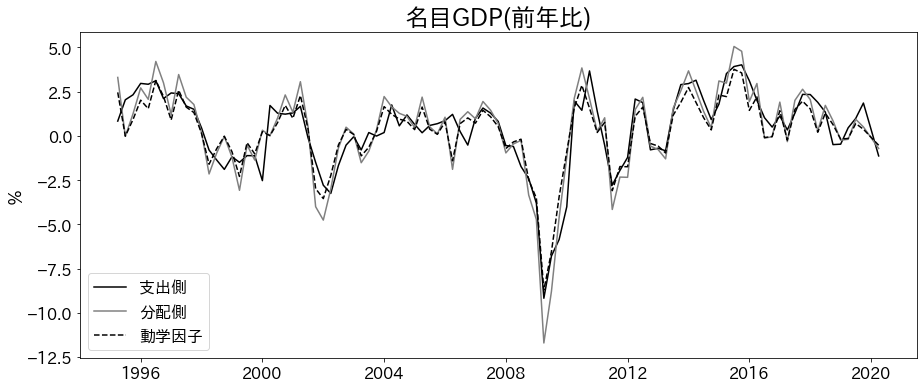

In [ ]:
#####
# グラフの描画
plt.title("名目GDP(前年比)", fontsize=24)
plt.plot(dti[4:], data_gdp.iloc[:, 0], label="支出側", color="black")
plt.plot(dti[4:], data_gdp.iloc[:, 1], label="分配側", color="grey")
plt.plot(dti[4:], result_dfm.states.smoothed, label="動学因子", color="black", linestyle="dashed")
plt.legend(loc="lower left", fontsize=16)
plt.tick_params(labelsize=16)
plt.ylabel("％", fontsize=16)

日本の月次マクロ経済変数219系列を対象に主成分分析による共通因子の推定("n_components"で共通因子の数を5と設定)を行うと、図4.2を作成できる。

In [ ]:
# プログラム4.3
# データの読み込み
rawdata = pd.read_excel("/content/drive/My Drive/data_4.xlsx", sheet_name="MS(JJIE2020)", header=[0])
msdata = rawdata.iloc[:, 1:]
dti = pd.date_range("1974-01-01", periods=len(msdata), freq="M")

# 主成分分析による共通因子(因子数は5個とする)の推定
scaler = StandardScaler()
scaler.fit(msdata)
msdata_std = scaler.transform(msdata)
pca = PCA(n_components=5)
pca.fit(msdata_std)
pca_factor = pca.transform(msdata_std)

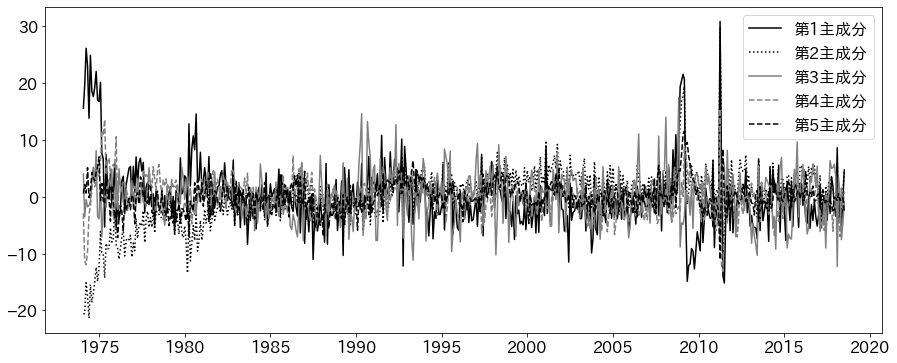

In [ ]:
#####
# グラフの描画
plt.plot(dti, pca_factor[:, 0], label="第1主成分", color="black")
plt.plot(dti, pca_factor[:, 1], label="第2主成分", color="black", linestyle="dotted")
plt.plot(dti, pca_factor[:, 2], label="第3主成分", color="grey")
plt.plot(dti, pca_factor[:, 3], label="第4主成分", color="grey", linestyle="dashed")
plt.plot(dti, pca_factor[:, 4], label="第5主成分", color="black", linestyle="dashed")
plt.legend(loc="upper right", fontsize=16)
plt.tick_params(labelsize=16)

Bai and Ng (2002)の情報量規準による共通因子数の選択は、以下のコードで計算される。なお、Bai and Ng (2002)の情報量規準では、6種類の式(4.3節の(4.13)式から(4.18)式)が提示されているため、そのうちのいずれか1つを選択するようにコードは作成されている。

In [ ]:
# プログラム4.4
MAX_K = 20  # 最大因子数（20系列）

# Bai and Ng (2002)の情報量規準による共通因子数の選択
bn_result = np.zeros(MAX_K)
# 情報量規準の式6種類の中から1つ選択
equation = str(input("情報量規準の式を選択してください(1~6): "))
for npc in range(1, MAX_K + 1):
    scaler = StandardScaler()
    scaler.fit(msdata)
    msdata_std = scaler.transform(msdata)
    pca = PCA(n_components=npc)
    pca.fit(msdata_std)
    pca_factor = pca.transform(msdata_std)
    df_pca_factor = pd.DataFrame(pca_factor)
    bnols = LinearRegression()
    bnols.fit(df_pca_factor, msdata_std)
    fitted = bnols.predict(df_pca_factor)
    sigmahat = ((((msdata_std - fitted) ** 2).sum(axis=0)).sum(axis=0)) / (
        len(msdata) * len(msdata.T)
    )
    pca_factor_MAX_K = pca.transform(msdata_std)
    df_pca_factor_MAX_K = pd.DataFrame(pca_factor_MAX_K)
    bnols_MAX_K = LinearRegression()
    bnols_MAX_K.fit(df_pca_factor_MAX_K, msdata_std)
    fitted_MAX_K = bnols_MAX_K.predict(df_pca_factor_MAX_K)
    sigmahat_MAX_K = ((((msdata_std - fitted_MAX_K) ** 2).sum(axis=0)).sum(axis=0)) / (
        len(msdata) * len(msdata.T)
    )
    if equation == "1":
        bn_result[npc - 1] = math.log(sigmahat) + npc * (
            (len(msdata.T) + len(msdata)) / (len(msdata.T) * len(msdata))
        ) * math.log((len(msdata.T) * len(msdata)) / (len(msdata.T) + len(msdata)))
    elif equation == "2":
        bn_result[npc - 1] = math.log(sigmahat) + npc * (
            (len(msdata.T) + len(msdata)) / (len(msdata.T) * len(msdata))
        ) * math.log(min(len(msdata.T), len(msdata)))
    elif equation == "3":
        bn_result[npc - 1] = math.log(sigmahat) + npc * (
            math.log(min(len(msdata.T), len(msdata))) / min(len(msdata.T), len(msdata))
        )
    elif equation == "4":
        bn_result[npc - 1] = sigmahat + npc * sigmahat_MAX_K * (
            (len(msdata.T) + len(msdata)) / (len(msdata.T) * len(msdata))
        ) * math.log((len(msdata.T) * len(msdata)) / (len(msdata.T) + len(msdata)))
    elif equation == "5":
        bn_result[npc - 1] = sigmahat + npc * sigmahat_MAX_K * (
            (len(msdata.T) + len(msdata)) / (len(msdata.T) * len(msdata))
        ) * math.log(min(len(msdata.T), len(msdata)))
    elif equation == "6":
        bn_result[npc - 1] = sigmahat + npc * sigmahat_MAX_K * (
            math.log(min(len(msdata.T), len(msdata))) / min(len(msdata.T), len(msdata))
        )
best_npc = pd.DataFrame(bn_result).idxmin() + 1

# 結果表の出力
df_table = pd.DataFrame([bn_result])
df_table.columns = [f"主成分の数={i+1}" for i in range(MAX_K)]
df_table.index = ["Bai and Ngの情報量規準"]
print(df_table)
print(f"最適な主成分の数={best_npc.to_numpy()}")

情報量規準の式を選択してください(1~6): 1
                   主成分の数=1   主成分の数=2   主成分の数=3   主成分の数=4   主成分の数=5   主成分の数=6  \
Bai and Ngの情報量規準 -0.129169 -0.246363 -0.323885 -0.357859 -0.375523 -0.390271   

                   主成分の数=7   主成分の数=8   主成分の数=9  主成分の数=10  主成分の数=11  主成分の数=12  \
Bai and Ngの情報量規準 -0.402084 -0.415507 -0.425298 -0.428477 -0.429728 -0.430495   

                  主成分の数=13  主成分の数=14  主成分の数=15  主成分の数=16  主成分の数=17  主成分の数=18  \
Bai and Ngの情報量規準 -0.430769 -0.428617 -0.424698  -0.42106 -0.416208 -0.411317   

                  主成分の数=19  主成分の数=20  
Bai and Ngの情報量規準 -0.406312 -0.400833  
最適な主成分の数=[13]


Onatski (2010)の方法による共通因子数の選択は、以下のコードで計算される。

In [ ]:
# プログラム4.5
# Onatski (2010)の方法による共通因子数の選択
scaler = StandardScaler()
scaler.fit(msdata)
msdata_std = scaler.transform(msdata)
lambda_eig = pd.DataFrame(
    np.linalg.eig(np.dot(msdata_std.T, msdata_std) / len(msdata_std))
)
j = MAX_K + 1
best_npc = MAX_K
diff_lambda_eig = (
    np.ravel(lambda_eig.iloc[0, :-1]) - np.ravel(lambda_eig.iloc[0, 1:])
)[0:j]
while best_npc != j:
    y = [
        lambda_eig.iloc[0, j + 1],
        lambda_eig.iloc[0, j + 2],
        lambda_eig.iloc[0, j + 3],
        lambda_eig.iloc[0, j + 4],
        lambda_eig.iloc[0, j + 5],
    ]
    x = [
        (j - 1) ** (2 / 3),
        (j) ** (2 / 3),
        (j + 1) ** (2 / 3),
        (j + 2) ** (2 / 3),
        (j + 3) ** (2 / 3),
    ]
    ools = LinearRegression()
    ools.fit(pd.DataFrame(x), pd.DataFrame(y))
    delta = 2 * np.abs(ools.coef_)
    check = diff_lambda_eig >= delta
    if not check.any() == True:
        best_npc = 0
    else:
        best_npc = np.max(np.where(check==True)[1]) + 1
    if j == best_npc:
        break
    else:
        j = best_npc + 1

# 結果の出力
print(f"最適な主成分の数={best_npc}")

最適な主成分の数=4


Ahn and Horenstein (2013)の方法による共通因子数の選択は、以下のコードで計算される。

In [ ]:
# プログラム4.6
# Ahn and Horenstein (2013)の方法による共通因子数の選択
ah_result = np.zeros(MAX_K + 1)
for npc in range(1, MAX_K + 2):
    scaler = StandardScaler()
    scaler.fit(msdata)
    msdata_std = scaler.transform(msdata)
    pca = PCA(n_components=npc)
    pca.fit(msdata_std)
    pca_factor = pca.transform(msdata_std)
    df_pca_factor = pd.DataFrame(pca_factor)
    ahols = LinearRegression()
    ahols.fit(df_pca_factor, msdata_std)
    fitted = ahols.predict(df_pca_factor)
    ah_ssr = (((msdata_std - fitted) ** 2).sum(axis=0)).sum(axis=0)
    ah_tss = ((msdata_std**2).sum(axis=0)).sum(axis=0)
    trace = 1 - ah_ssr / ah_tss
    ah_result[npc - 1] = trace
marg_1 = pd.DataFrame(ah_result)
marg_2 = pd.concat(
    [pd.DataFrame(np.zeros(len(marg_1.T))), marg_1.iloc[0 : marg_1.shape[0] - 1].T],
    axis=1,
)
marg = pd.DataFrame(marg_1.T.to_numpy() - marg_2.to_numpy())
marg_trans = marg.T
aher_num = marg_trans[0 : marg.shape[1] - 1].T
aher_den = marg_trans[1 : marg.shape[1]].T
aher = pd.DataFrame(aher_num.to_numpy() / aher_den.to_numpy())
best_npc = pd.DataFrame(aher.T).idxmax() + 1

# 結果表の出力
df_table = pd.DataFrame(aher.to_numpy())
df_table.columns = [f"主成分の数={i+1}" for i in range(MAX_K)]
df_table.index = ["Ahn and Horensteinの方法"]
print(df_table)
print(f"最適な主成分の数={best_npc.to_numpy()}")

                        主成分の数=1   主成分の数=2   主成分の数=3  主成分の数=4   主成分の数=5  \
Ahn and Horensteinの方法  1.262112  1.549946  1.808501  1.40489  1.114754   

                        主成分の数=6   主成分の数=7   主成分の数=8   主成分の数=9  主成分の数=10  \
Ahn and Horensteinの方法  1.116182  1.009437  1.134885  1.232538  1.094403   

                       主成分の数=11  主成分の数=12  主成分の数=13  主成分の数=14  主成分の数=15  \
Ahn and Horensteinの方法  1.049022  1.050956  1.110594  1.096207  1.018858   

                       主成分の数=16  主成分の数=17  主成分の数=18  主成分の数=19  主成分の数=20  
Ahn and Horensteinの方法  1.069422   1.03807   1.02573  1.047766  1.016437  
最適な主成分の数=[3]


主成分分析により抽出した共通因子を用いて動学因子モデルの予測を行うと、図4.3を作成できる。

In [ ]:
# プログラム4.7
# 主成分分析による動学因子モデルの予測
predict_result_list, sqe_result_list, ah_result_list = [], [], []
PERIOD = 120  # 訓練データのサンプルサイズ（120か月）
H = 12  # 予測期間（12か月）
MAX_K = 20  # 最大因子数（20系列）
data_y = pd.DataFrame(msdata.x126)
data_x = pd.DataFrame(msdata)

vsample, hsample = len(data_x), len(data_x.columns)
for i in range((vsample - H) - PERIOD):
    predict_result, sqe_result, ah_result = (
        np.zeros(MAX_K + 1),
        np.zeros(MAX_K + 1),
        np.zeros(MAX_K + 1),
    )
    for npc in range(1, MAX_K + 1 + 1):
        train_x = data_x[i : i + PERIOD]
        test_x = data_x[i : i + PERIOD + 1]
        scaler = StandardScaler()
        scaler.fit(train_x)
        train_x_std = scaler.transform(train_x)
        scaler.fit(test_x)
        test_x_std = scaler.transform(test_x)
        # 主成分分析
        pca = PCA(n_components=npc)
        pca.fit(train_x_std)
        pca_train = pca.transform(train_x_std)
        pca.fit(test_x_std)
        pca_test = pca.transform(test_x_std)[PERIOD : PERIOD + 1]
        
        df_pca_train = pd.DataFrame(pca_train)
        df_pca_test = pd.DataFrame(pca_test)
        train_x = pd.concat(
            [pd.DataFrame(df_pca_train.to_numpy()), 
             pd.DataFrame(data_y[i : i + PERIOD].to_numpy())], 
            axis=1,
        )
        train_y = data_y[H + i : H + i + PERIOD]
        test_x = pd.concat(
            [pd.DataFrame(df_pca_test.to_numpy()), 
             pd.DataFrame(data_y[i + PERIOD : i + PERIOD + 1].to_numpy())], 
            axis=1,
        )
        test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
        # モデル推定
        model = LinearRegression()
        model.fit(train_x, train_y)
        forecast = model.predict(test_x)
        sqe = (test_y - forecast) ** 2
        ahols = LinearRegression()
        ahols.fit(train_x, train_y)
        fitted = ahols.predict(train_x)
        ah_ssr = (((train_x - fitted) ** 2).sum(axis=0)).sum(axis=0)
        ah_tss = ((train_x**2).sum(axis=0)).sum(axis=0)
        trace = 1 - ah_ssr / ah_tss
        predict_result[npc - 1] = forecast
        sqe_result[npc - 1] = sqe.sum(axis=0)
        ah_result[npc - 1] = trace
    marg_1 = pd.DataFrame(ah_result)
    marg_2 = pd.concat(
        [pd.DataFrame(np.zeros(len(marg_1.T))), marg_1.iloc[0 : marg_1.shape[0] - 1].T],
        axis=1,
    )
    marg = pd.DataFrame(marg_1.T.to_numpy() - marg_2.to_numpy())
    marg_trans = marg.T
    aher_num = marg_trans[0 : marg.shape[1] - 1].T
    aher_den = marg_trans[1 : marg.shape[1]].T
    aher = pd.DataFrame(aher_num.to_numpy() / aher_den.to_numpy())
    best_npc = pd.DataFrame(aher.T).idxmax() + 1
    predict_result_list.append(predict_result[best_npc - 1])
    sqe_result_list.append(sqe_result[best_npc - 1])
    ah_result_list.append(best_npc)

In [ ]:
#####
# AR予測
predict_resultAR_list, sqe_resultAR_list = [], []
PERIOD = 120  # 訓練データのサンプルサイズ（120か月）
H = 12  # 予測期間（12か月）

predict_resultAR = np.zeros((vsample - H) - PERIOD)
sqe_resultAR = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # 訓練データの指定
    train_x = data_y[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    # テストデータの指定
    test_x = data_y[i + PERIOD : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    # ARモデル
    model = LinearRegression()
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_resultAR[i] = forecast
    sqe = ((test_y - forecast) ** 2).sum(axis=0)
    sqe_resultAR[i] = sqe

predict_resultAR_list.append(predict_resultAR)
sqe_resultAR_list.append(sqe_resultAR)

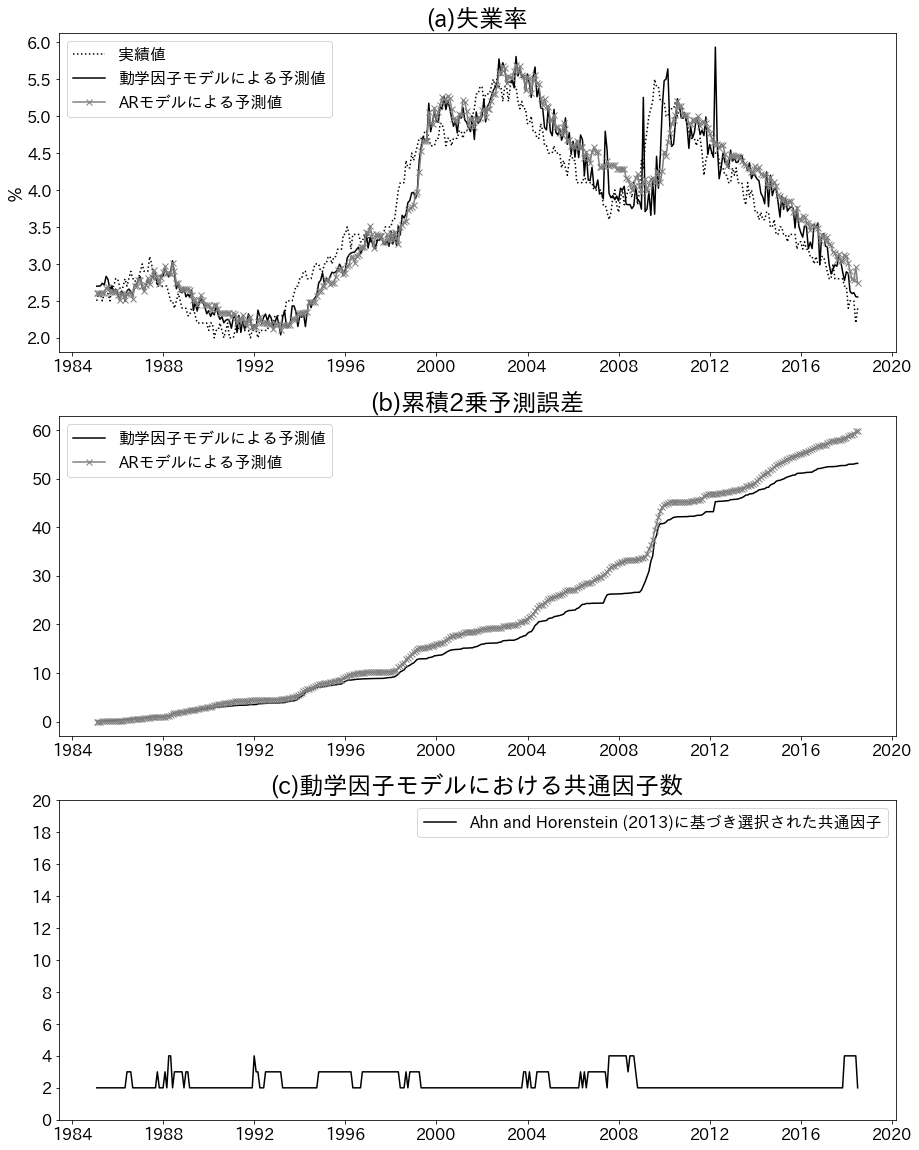

In [ ]:
#####
# グラフの描画
fig = plt.figure(figsize=(15, 20))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)
ax1.set_title("(a)失業率", fontsize=24)
ax1.plot(dti[H + PERIOD :], msdata.x126[H + PERIOD :], label="実績値", color="black", linestyle="dotted")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result_list), label="動学因子モデルによる予測値", color="black")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_resultAR_list), label="ARモデルによる予測値", color="grey", marker="x")
ax1.legend(loc="upper left", fontsize=16)
ax1.set_ylabel("％", fontsize=16)
ax1.tick_params(labelsize=16)
ax2.set_title("(b)累積2乗予測誤差", fontsize=24)
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result_list).cumsum(), label="動学因子モデルによる予測値", color="black")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_resultAR_list).cumsum(), label="ARモデルによる予測値", color="grey", marker="x")
ax2.legend(loc="upper left", fontsize=16)
ax2.tick_params(labelsize=16)
ax3.set_title("(c)動学因子モデルにおける共通因子数", fontsize=24)
ax3.plot(dti[H + PERIOD :], ah_result_list, label="Ahn and Horenstein (2013)に基づき選択された共通因子", color="black")
ax3.legend(loc="upper right", fontsize=16)
ax3.tick_params(labelsize=16)
ax3.set_yticks(np.arange(0, MAX_K + 1, step=2))

混合頻度データを用いた動学因子モデルの予測を行う。はじめに、データを読み込む。

In [ ]:
# プログラム4.8
# 混合頻度データを用いた動学因子モデルの予測
# データの読み込み
data = pd.read_excel("/content/drive/My Drive/data_4.xlsx", sheet_name="混合頻度データ", header=[0])
data_m = data.iloc[:, 3:]
data_q = data.iloc[:, 1 : 1 + 1]
data_q = data_q.dropna()
mdlen, qdlen = len(data_m), len(data_q)
mdti = pd.date_range("1994-01-01", periods=mdlen, freq="MS")
qdti = pd.date_range("1994-01-01", periods=qdlen, freq="QS")

因子ブリッジモデルは、以下のコードで計算できる。

In [ ]:
# プログラム4.9
PERIOD = 60  # 訓練データのサンプルサイズ（60四半期=180か月）

# ブリッジモデル
NPC_BRIDGE = 3  # 因子数（3系列）
predict_result1_list, predict_result2_list, predict_result3_list = [], [], []
predict_result = np.zeros(((qdlen - 1) - PERIOD) * 3)
for k in range(1, qdlen - PERIOD):

    # M3型ブリッジモデルを作成
    df_hatdata3 = data_m.iloc[3 * k : 3 * (k + PERIOD + 1), :]
    scaler = StandardScaler()
    scaler.fit(df_hatdata3)
    df_hatdata3_std = scaler.transform(df_hatdata3)
    pca = PCA(n_components=NPC_BRIDGE)
    pca.fit(df_hatdata3_std)
    pca_df_hatdata3 = pca.transform(df_hatdata3_std)
    mqdata_bbefore3 = pd.concat(
        [
            pd.DataFrame(pca_df_hatdata3),
            pd.DataFrame(df_hatdata3.iloc[:, 0].to_numpy()),
            pd.DataFrame(df_hatdata3.iloc[:, 40].to_numpy()),
        ],
        axis=1,
    )
    mqdata_before3 = mqdata_bbefore3.rolling(window=3, center=False).sum() / 3
    mqdata3 = np.zeros([PERIOD + 1, NPC_BRIDGE + 2])
    for i in range(PERIOD + 1):
        mqdata3[i, :] = mqdata_before3.iloc[3 * (i + 1) - 1, :]
    x3 = mqdata3[0:PERIOD, :]
    y = data_q.iloc[k : k + PERIOD]

    model = LinearRegression()
    model.fit(x3, y)
    predict_result[3 * (k - 1) + 2] = model.predict(mqdata3[PERIOD : PERIOD + 1, :])
    predict_result3_list.append(predict_result[(k - 1) * 3 + 2])

    # M2型ブリッジモデルを作成
    df_hatdata2 = data_m.iloc[3 * k - 1 : 3 * (k + PERIOD + 1) - 1, :]
    scaler = StandardScaler()
    scaler.fit(df_hatdata2)
    df_hatdata2_std = scaler.transform(df_hatdata2)
    pca = PCA(n_components=NPC_BRIDGE)
    pca.fit(df_hatdata2_std)
    pca_df_hatdata2 = pca.transform(df_hatdata2_std)
    mqdata_bbefore2 = pd.concat(
        [
            pd.DataFrame(pca_df_hatdata2),
            pd.DataFrame(df_hatdata2.iloc[:, 0].to_numpy()),
            pd.DataFrame(df_hatdata2.iloc[:, 40].to_numpy()),
        ],
        axis=1,
    )
    fitted21 = pd.DataFrame(np.zeros([1, NPC_BRIDGE + 2]))
    for j in range(NPC_BRIDGE + 2):
        tempx21 = pd.DataFrame(mqdata_bbefore2.iloc[:-1, j].to_numpy())
        tempy21 = pd.DataFrame(mqdata_bbefore2.iloc[1:, j].to_numpy())
        model = LinearRegression()
        model.fit(tempx21, tempy21)
        fitted21.iloc[0, j] = (
            model.intercept_ + model.coef_ * mqdata_bbefore2.iloc[-2, j]
        )
    hatdata2 = pd.concat(
        [pd.DataFrame(mqdata_bbefore2.iloc[1:, :].to_numpy()), fitted21], axis=0
    )
    mqdata_before2 = hatdata2.rolling(window=3, center=False).sum() / 3
    mqdata2 = np.zeros([PERIOD + 1, NPC_BRIDGE + 2])
    for i in range(0, PERIOD + 1):
        mqdata2[i, :] = mqdata_before2.iloc[3 * (i + 1) - 1, :]
    x2 = mqdata2[0:PERIOD, :]
    y = data_q.iloc[k : k + PERIOD]
    model = LinearRegression()
    model.fit(x2, y)
    predict_result[3 * (k - 1) + 1] = model.predict(mqdata2[PERIOD : PERIOD + 1, :])
    predict_result2_list.append(predict_result[(k - 1) * 3 + 1])

    # M1型ブリッジモデルを作成
    df_hatdata1 = data_m.iloc[3 * k - 2 : 3 * (k + PERIOD + 1) - 2, :]
    scaler = StandardScaler()
    scaler.fit(df_hatdata1)
    df_hatdata1_std = scaler.transform(df_hatdata1)
    pca = PCA(n_components=NPC_BRIDGE)
    pca.fit(df_hatdata1_std)
    pca_df_hatdata1 = pca.transform(df_hatdata1_std)
    mqdata_bbefore1 = pd.concat(
        [
            pd.DataFrame(pca_df_hatdata1),
            pd.DataFrame(df_hatdata1.iloc[:, 0].to_numpy()),
            pd.DataFrame(df_hatdata1.iloc[:, 40].to_numpy()),
        ],
        axis=1,
    )
    fitted11, fitted12 = pd.DataFrame(np.zeros([1, NPC_BRIDGE + 2])), pd.DataFrame(
        np.zeros([1, NPC_BRIDGE + 2])
    )
    for j in range(NPC_BRIDGE + 2):
        tempx11 = pd.DataFrame(mqdata_bbefore1.iloc[:-1, j].to_numpy())
        tempy11 = pd.DataFrame(mqdata_bbefore1.iloc[1:, j].to_numpy())
        model = LinearRegression()
        model.fit(tempx11, tempy11)
        fitted11.iloc[0, j] = (
            model.intercept_ + model.coef_ * mqdata_bbefore1.iloc[-1, j]
        )
        tempx12 = pd.DataFrame(mqdata_bbefore1.iloc[:-2, j].to_numpy())
        tempy12 = pd.DataFrame(mqdata_bbefore1.iloc[2:, j].to_numpy())
        model = LinearRegression()
        model.fit(tempx12, tempy12)
        fitted12.iloc[0, j] = (
            model.intercept_ + model.coef_ * mqdata_bbefore1.iloc[-1, j]
        )
    hatdata1 = pd.concat(
        [pd.DataFrame(mqdata_bbefore1.iloc[2:, :].to_numpy()), fitted11, fitted12],
        axis=0,
    )
    mqdata_before1 = hatdata1.rolling(window=3, center=False).sum() / 3
    mqdata1 = np.zeros([PERIOD + 1, NPC_BRIDGE + 2])
    for i in range(PERIOD + 1):
        mqdata1[i, :] = mqdata_before1.iloc[3 * (i + 1) - 1, :]
    x1 = mqdata1[0:PERIOD, :]
    y = data_q.iloc[k : k + PERIOD]
    model = LinearRegression()
    model.fit(x1, y)
    predict_result[3 * (k - 1)] = model.predict(mqdata1[PERIOD : PERIOD + 1, :])
    predict_result1_list.append(predict_result[(k - 1) * 3])

因子MIDASモデルは、以下のコードで計算できる。

In [ ]:
# プログラム4.10
# MIDASモデル
NPC_MIDAS = 1  # 因子数（1系列）
predict_result4_list, predict_result5_list, predict_result6_list = [], [], []
predict_result = np.zeros(((qdlen - 1) - PERIOD) * 3)
for k in range(1, qdlen - PERIOD):
    # 非線形最小2乗法によりパラメータを推定
    def fit_func(parameter, xx, y):
        cf1, cf2, cf3, x11, x12, x13, x21, x22, x23 = xx
        a, b, c, d, e, f = parameter
        residual = (
            y
            - a
            - b
            * (
                (np.exp(0) / np.exp(c * 3 + d * 5)) * x13
                + (np.exp(c * 1 + d * 1) / np.exp(c * 3 + d * 5)) * x12
                + (np.exp(c * 2 + d * 4) / np.exp(c * 3 + d * 5)) * x11
            )
            - e
            * (
                (np.exp(0) / np.exp(c * 3 + d * 5)) * x23
                + (np.exp(c * 1 + d * 1) / np.exp(c * 3 + d * 5)) * x22
                + (np.exp(c * 2 + d * 4) / np.exp(c * 3 + d * 5)) * x21
            )
            - f
            * (
                (np.exp(0) / np.exp(c * 3 + d * 5)) * cf3
                + (np.exp(c * 1 + d * 1) / np.exp(c * 3 + d * 5)) * cf2
                + (np.exp(c * 2 + d * 4) / np.exp(c * 3 + d * 5)) * cf1
            )
        )
        return residual

    
    parameter0 = [0, 0, 0, 0, 0, 0]

    # M3型MIDASモデルを作成
    data_y = pd.DataFrame(data_q[k : k + PERIOD].to_numpy())
    x3 = data_m[3 * k : 3 * (k + PERIOD + 1)].to_numpy()
    scaler = StandardScaler()
    scaler.fit(x3)
    x3_std = scaler.transform(x3)
    pca = PCA(n_components=NPC_MIDAS)
    pca.fit(x3_std)
    pca_x3 = pca.transform(x3_std)
    f31 = np.ravel(pd.DataFrame(pca_x3[0:-3:3]))
    f32 = np.ravel(pd.DataFrame(pca_x3[1:-3:3]))
    f33 = np.ravel(pd.DataFrame(pca_x3[2:-3:3]))
    x11 = np.ravel(pd.DataFrame(x3[0:-3:3][:, 0]))
    x12 = np.ravel(pd.DataFrame(x3[1:-3:3][:, 0]))
    x13 = np.ravel(pd.DataFrame(x3[2:-3:3][:, 0]))
    x21 = np.ravel(pd.DataFrame(x3[0:-3:3][:, 40]))
    x22 = np.ravel(pd.DataFrame(x3[1:-3:3][:, 40]))
    x23 = np.ravel(pd.DataFrame(x3[2:-3:3][:, 40]))
    result = sp.optimize.leastsq(
        fit_func,
        parameter0,
        args=(
            (f31, f32, f33, x11, x12, x13, x21, x22, x23),
            np.ravel(data_y.to_numpy()),
        ),
    )
    a_fit, b_fit, c_fit, d_fit, e_fit, f_fit = (
        result[0][0],
        result[0][1],
        result[0][2],
        result[0][3],
        result[0][4],
        result[0][5],
    )
    f31_p = np.ravel(pd.DataFrame(pca_x3[-3, :]))
    f32_p = np.ravel(pd.DataFrame(pca_x3[-2, :]))
    f33_p = np.ravel(pd.DataFrame(pca_x3[-1, :]))
    x11_p = np.ravel(pd.DataFrame([x3[-3][0]]))
    x12_p = np.ravel(pd.DataFrame([x3[-2][0]]))
    x13_p = np.ravel(pd.DataFrame([x3[-1][0]]))
    x21_p = np.ravel(pd.DataFrame([x3[-3][40]]))
    x22_p = np.ravel(pd.DataFrame([x3[-2][40]]))
    x23_p = np.ravel(pd.DataFrame([x3[-1][40]]))
    predict_result[3 * (k - 1) + 2] = (
        a_fit
        + b_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5)) * x13_p
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5)) * x12_p
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5)) * x11_p
        )
        + e_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5)) * x23_p
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5)) * x22_p
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5)) * x21_p
        )
        + f_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5)) * f33_p
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5)) * f32_p
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5)) * f31_p
        )
    )
    predict_result6_list.append(predict_result[3 * (k - 1) + 2])

    # M2型MIDASモデルを作成
    data_y = pd.DataFrame(data_q[k : k + PERIOD].to_numpy())
    x2 = data_m[3 * k - 1 : 3 * (k + PERIOD + 1) - 1].to_numpy()
    scaler = StandardScaler()
    scaler.fit(x2)
    x2_std = scaler.transform(x2)
    pca = PCA(n_components=NPC_MIDAS)
    pca.fit(x2_std)
    pca_x2 = pca.transform(x2_std)
    f23 = np.ravel(pd.DataFrame(pca_x2[0:-3:3]))
    f21 = np.ravel(pd.DataFrame(pca_x2[1:-3:3]))
    f22 = np.ravel(pd.DataFrame(pca_x2[2:-3:3]))
    x13 = np.ravel(pd.DataFrame(x2[0:-3:3][:, 0]))
    x11 = np.ravel(pd.DataFrame(x2[1:-3:3][:, 0]))
    x12 = np.ravel(pd.DataFrame(x2[2:-3:3][:, 0]))
    x23 = np.ravel(pd.DataFrame(x2[0:-3:3][:, 40]))
    x21 = np.ravel(pd.DataFrame(x2[1:-3:3][:, 40]))
    x22 = np.ravel(pd.DataFrame(x2[2:-3:3][:, 40]))
    result = sp.optimize.leastsq(
        fit_func,
        parameter0,
        args=(
            (f23, f21, f22, x13, x11, x12, x23, x21, x22),
            np.ravel(data_y.to_numpy()),
        ),
    )
    a_fit, b_fit, c_fit, d_fit, e_fit, f_fit = (
        result[0][0],
        result[0][1],
        result[0][2],
        result[0][3],
        result[0][4],
        result[0][5],
    )
    f23_p = np.ravel(pd.DataFrame(pca_x2[-3, :]))
    f21_p = np.ravel(pd.DataFrame(pca_x2[-2, :]))
    f22_p = np.ravel(pd.DataFrame(pca_x2[-1, :]))
    x13_p = np.ravel(pd.DataFrame([x2[-3][0]]))
    x11_p = np.ravel(pd.DataFrame([x2[-2][0]]))
    x12_p = np.ravel(pd.DataFrame([x2[-1][0]]))
    x23_p = np.ravel(pd.DataFrame([x2[-3][40]]))
    x21_p = np.ravel(pd.DataFrame([x2[-2][40]]))
    x22_p = np.ravel(pd.DataFrame([x2[-1][40]]))
    predict_result[3 * (k - 1) + 1] = (
        a_fit
        + b_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5)) * x12_p
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5)) * x11_p
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5)) * x13_p
        )
        + e_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5)) * x22_p
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5)) * x21_p
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5)) * x23_p
        )
        + f_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5)) * f22_p
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5)) * f21_p
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5)) * f23_p
        )
    )
    predict_result5_list.append(predict_result[3 * (k - 1) + 1])

    # M1型MIDASモデルを作成
    data_y = pd.DataFrame(data_q[k : k + PERIOD].to_numpy())
    x1 = data_m[3 * k - 2 : 3 * (k + PERIOD + 1) - 2].to_numpy()
    scaler = StandardScaler()
    scaler.fit(x1)
    x1_std = scaler.transform(x1)
    pca = PCA(n_components=NPC_MIDAS)
    pca.fit(x1_std)
    pca_x1 = pca.transform(x1_std)
    f12 = np.ravel(pd.DataFrame(pca_x1[0:-3:3]))
    f13 = np.ravel(pd.DataFrame(pca_x1[1:-3:3]))
    f11 = np.ravel(pd.DataFrame(pca_x1[2:-3:3]))
    x12 = np.ravel(pd.DataFrame(x1[0:-3:3][:, 0]))
    x13 = np.ravel(pd.DataFrame(x1[1:-3:3][:, 0]))
    x11 = np.ravel(pd.DataFrame(x1[2:-3:3][:, 0]))
    x22 = np.ravel(pd.DataFrame(x1[0:-3:3][:, 40]))
    x23 = np.ravel(pd.DataFrame(x1[1:-3:3][:, 40]))
    x21 = np.ravel(pd.DataFrame(x1[2:-3:3][:, 40]))
    result = sp.optimize.leastsq(
        fit_func,
        parameter0,
        args=(
            (f12, f13, f11, x12, x13, x11, x22, x23, x21),
            np.ravel(data_y.to_numpy()),
        ),
    )
    a_fit, b_fit, c_fit, d_fit, e_fit, f_fit = (
        result[0][0],
        result[0][1],
        result[0][2],
        result[0][3],
        result[0][4],
        result[0][5],
    )
    f12_p = np.ravel(pd.DataFrame(pca_x1[-3, :]))
    f13_p = np.ravel(pd.DataFrame(pca_x1[-2, :]))
    f11_p = np.ravel(pd.DataFrame(pca_x1[-1, :]))
    x12_p = np.ravel(pd.DataFrame([x1[-3][0]]))
    x13_p = np.ravel(pd.DataFrame([x1[-2][0]]))
    x11_p = np.ravel(pd.DataFrame([x1[-1][0]]))
    x22_p = np.ravel(pd.DataFrame([x1[-3][40]]))
    x23_p = np.ravel(pd.DataFrame([x1[-2][40]]))
    x21_p = np.ravel(pd.DataFrame([x1[-1][40]]))
    predict_result[3 * (k - 1)] = (
        a_fit
        + b_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5)) * x11_p
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5)) * x13_p
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5)) * x12_p
        )
        + e_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5)) * x21_p
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5)) * x23_p
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5)) * x22_p
        )
        + f_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5)) * f11_p
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5)) * f13_p
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5)) * f12_p
        )
    )
    predict_result4_list.append(predict_result[3 * (k - 1)])

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1400.
  warnings.warn(errors[info][0], RuntimeWarning)


因子U-MIDASモデルは、以下のコードで計算できる。

In [ ]:
# プログラム4.11
# U-MIDASモデル
NPC_UMIDAS = 3  # 因子数（3系列）
predict_result7_list, predict_result8_list, predict_result9_list = [], [], []
predict_result = np.zeros(((qdlen - 1) - PERIOD) * 3)
for k in range(1, qdlen - PERIOD):

    # M3型U-MIDASモデルを作成
    y = pd.DataFrame(data_q[k : k + PERIOD].to_numpy())
    x3 = data_m[3 * k : 3 * (k + PERIOD + 1)].to_numpy()
    scaler = StandardScaler()
    scaler.fit(x3)
    x3_std = scaler.transform(x3)
    pca = PCA(n_components=NPC_UMIDAS)
    pca.fit(x3_std)
    pca_x3 = pca.transform(x3_std)
    f31 = pd.DataFrame(pca_x3[0:-3:3])
    f32 = pd.DataFrame(pca_x3[1:-3:3])
    f33 = pd.DataFrame(pca_x3[2:-3:3])
    x11 = pd.DataFrame(x3[0:-3:3][:, 0])
    x12 = pd.DataFrame(x3[1:-3:3][:, 0])
    x13 = pd.DataFrame(x3[2:-3:3][:, 0])
    x21 = pd.DataFrame(x3[0:-3:3][:, 40])
    x22 = pd.DataFrame(x3[1:-3:3][:, 40])
    x23 = pd.DataFrame(x3[2:-3:3][:, 40])
    x = pd.concat([f31, f32, f33, x11, x12, x13, x21, x22, x23], axis=1)
    f31_p = pd.DataFrame(pca_x3[-3, :]).T
    f32_p = pd.DataFrame(pca_x3[-2, :]).T
    f33_p = pd.DataFrame(pca_x3[-1, :]).T
    x11_p = pd.DataFrame([x3[-3][0]])
    x12_p = pd.DataFrame([x3[-2][0]])
    x13_p = pd.DataFrame([x3[-1][0]])
    x21_p = pd.DataFrame([x3[-3][40]])
    x22_p = pd.DataFrame([x3[-2][40]])
    x23_p = pd.DataFrame([x3[-1][40]])
    x_p = pd.concat([f31_p, f32_p, f33_p, x11_p, x12_p, x13_p, x21_p, x22_p, x23_p], axis=1)
    model = LinearRegression()
    model.fit(x, y)
    predict_result[3 * (k - 1) + 2] = model.predict(x_p)
    predict_result9_list.append(predict_result[3 * (k - 1) + 2])

    # M2型U-MIDASモデルを作成
    y = pd.DataFrame(data_q[k : k + PERIOD].to_numpy())
    x2 = data_m[3 * k - 1 : 3 * (k + PERIOD + 1) - 1].to_numpy()
    scaler = StandardScaler()
    scaler.fit(x2)
    x2_std = scaler.transform(x2)
    pca = PCA(n_components=NPC_UMIDAS)
    pca.fit(x2_std)
    pca_x2 = pca.transform(x2_std)
    f23 = pd.DataFrame(pca_x2[0:-3:3])
    f21 = pd.DataFrame(pca_x2[1:-3:3])
    f22 = pd.DataFrame(pca_x2[2:-3:3])
    x13 = pd.DataFrame(x2[0:-3:3][:, 0])
    x11 = pd.DataFrame(x2[1:-3:3][:, 0])
    x12 = pd.DataFrame(x2[2:-3:3][:, 0])
    x23 = pd.DataFrame(x2[0:-3:3][:, 40])
    x21 = pd.DataFrame(x2[1:-3:3][:, 40])
    x22 = pd.DataFrame(x2[2:-3:3][:, 40])
    x = pd.concat([f23, f21, f22, x13, x11, x12, x23, x21, x22], axis=1)
    f23_p = pd.DataFrame(pca_x2[-3, :]).T
    f21_p = pd.DataFrame(pca_x2[-2, :]).T
    f22_p = pd.DataFrame(pca_x2[-1, :]).T
    x13_p = pd.DataFrame([x2[-3][0]])
    x11_p = pd.DataFrame([x2[-2][0]])
    x12_p = pd.DataFrame([x2[-1][0]])
    x23_p = pd.DataFrame([x2[-3][40]])
    x21_p = pd.DataFrame([x2[-2][40]])
    x22_p = pd.DataFrame([x2[-1][40]])
    x_p = pd.concat([f23_p, f21_p, f22_p, x13_p, x11_p, x12_p, x23_p, x21_p, x22_p], axis=1)
    model = LinearRegression()
    model.fit(x, y)
    predict_result[3 * (k - 1) + 1] = model.predict(x_p)
    predict_result8_list.append(predict_result[3 * (k - 1) + 1])

    # M1型U-MIDASモデルを作成
    y = pd.DataFrame(data_q[k : k + PERIOD].to_numpy())
    x1 = data_m[3 * k - 2 : 3 * (k + PERIOD + 1) - 2].to_numpy()
    scaler = StandardScaler()
    scaler.fit(x1)
    x1_std = scaler.transform(x1)
    pca = PCA(n_components=NPC_UMIDAS)
    pca.fit(x1_std)
    pca_x1 = pca.transform(x1_std)
    f12 = pd.DataFrame(pca_x1[0:-3:3])
    f13 = pd.DataFrame(pca_x1[1:-3:3])
    f11 = pd.DataFrame(pca_x1[2:-3:3])
    x12 = pd.DataFrame(x1[0:-3:3][:, 0])
    x13 = pd.DataFrame(x1[1:-3:3][:, 0])
    x11 = pd.DataFrame(x1[2:-3:3][:, 0])
    x22 = pd.DataFrame(x1[0:-3:3][:, 40])
    x23 = pd.DataFrame(x1[1:-3:3][:, 40])
    x21 = pd.DataFrame(x1[2:-3:3][:, 40])
    x = pd.concat([f12, f13, f11, x12, x13, x11, x22, x23, x21], axis=1)
    f12_p = pd.DataFrame(pca_x1[-3, :]).T
    f13_p = pd.DataFrame(pca_x1[-2, :]).T
    f11_p = pd.DataFrame(pca_x1[-1, :]).T
    x12_p = pd.DataFrame([x1[-3][0]])
    x13_p = pd.DataFrame([x1[-2][0]])
    x11_p = pd.DataFrame([x1[-1][0]])
    x22_p = pd.DataFrame([x1[-3][40]])
    x23_p = pd.DataFrame([x1[-2][40]])
    x21_p = pd.DataFrame([x1[-1][40]])
    x_p = pd.concat([f12_p, f13_p, f11_p, x12_p, x13_p, x11_p, x22_p, x23_p, x21_p], axis=1)
    model = LinearRegression()
    model.fit(x, y)
    predict_result[3 * (k - 1)] = model.predict(x_p)
    predict_result7_list.append(predict_result[3 * (k - 1)])

以上の結果をまとめると、図4.4を作成できる。

Text(0, 0.5, '％')

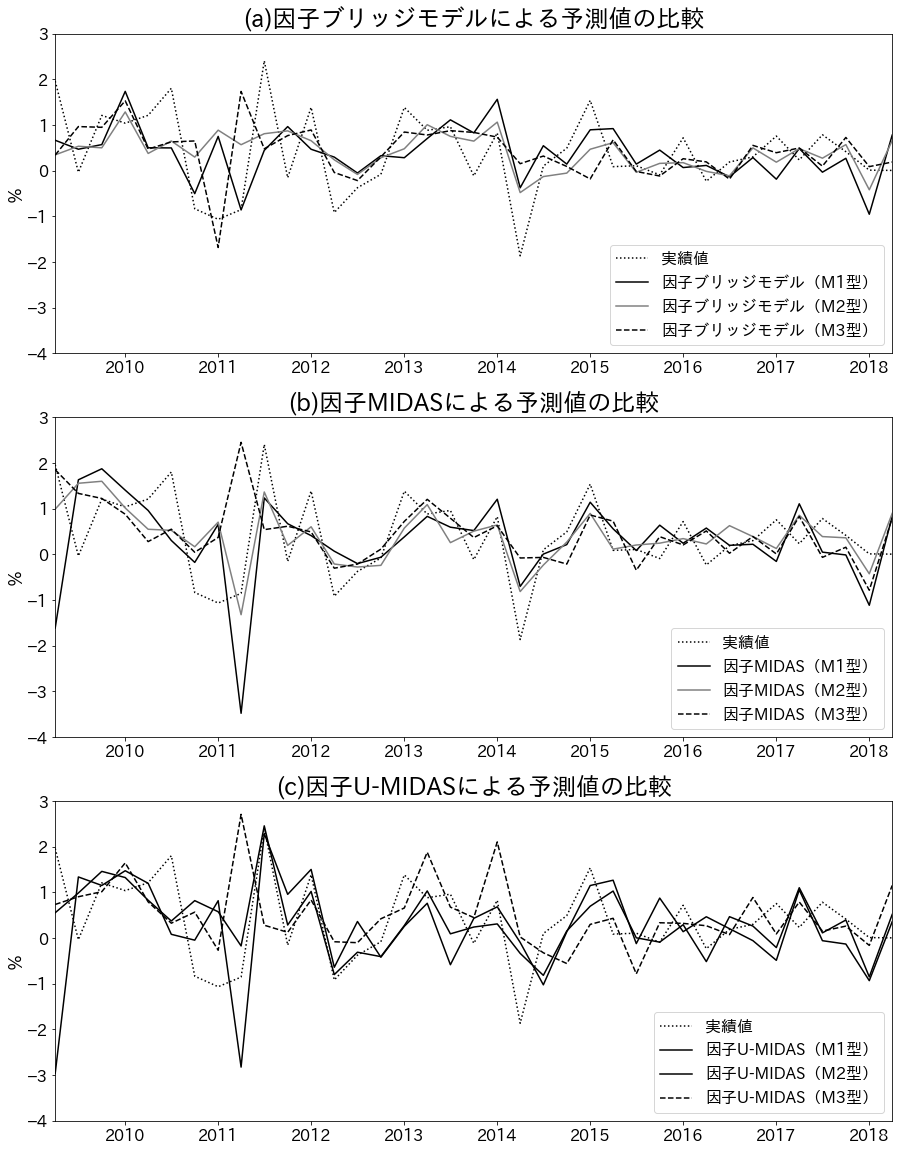

In [ ]:
#####
# グラフの描画
fig = plt.figure(figsize=(15, 20))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)
ax1.set_title("(a)因子ブリッジモデルによる予測値の比較", fontsize=24)
ax1.plot(qdti[PERIOD + 1 :], data_q[PERIOD+1:].to_numpy(), label="実績値", color="black", linestyle="dotted")
ax1.plot(qdti[PERIOD + 1 :], np.ravel(predict_result1_list), label="因子ブリッジモデル（M1型）", color="black")
ax1.plot(qdti[PERIOD + 1 :], np.ravel(predict_result2_list), label="因子ブリッジモデル（M2型）", color="grey")
ax1.plot(qdti[PERIOD + 1 :], np.ravel(predict_result3_list), label="因子ブリッジモデル（M3型）", color="black", linestyle="dashed")
ax1.legend(loc="lower right", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_xlim(qdti[PERIOD + 1], qdti[-1])
ax1.set_ylim(-4, 3)
ax1.set_ylabel("％", fontsize=16)
ax2.set_title("(b)因子MIDASによる予測値の比較", fontsize=24)
ax2.plot(qdti[PERIOD + 1 :], data_q[PERIOD+1:].to_numpy(), label="実績値", color="black", linestyle="dotted")
ax2.plot(qdti[PERIOD + 1 :], np.ravel(predict_result4_list), label="因子MIDAS（M1型）", color="black")
ax2.plot(qdti[PERIOD + 1 :], np.ravel(predict_result5_list), label="因子MIDAS（M2型）", color="grey")
ax2.plot(qdti[PERIOD + 1 :], np.ravel(predict_result6_list), label="因子MIDAS（M3型）", color="black", linestyle="dashed")
ax2.legend(loc="lower right", fontsize=16)
ax2.tick_params(labelsize=16)
ax2.set_xlim(qdti[PERIOD + 1], qdti[-1])
ax2.set_ylim(-4, 3)
ax2.set_ylabel("％", fontsize=16)
ax3.set_title("(c)因子U-MIDASによる予測値の比較", fontsize=24)
ax3.plot(qdti[PERIOD + 1 :], data_q[PERIOD+1:].to_numpy(), label="実績値", color="black", linestyle="dotted")
ax3.plot(qdti[PERIOD + 1 :], np.ravel(predict_result7_list), label="因子U-MIDAS（M1型）", color="black")
ax3.plot(qdti[PERIOD + 1 :], np.ravel(predict_result8_list), label="因子U-MIDAS（M2型）", color="black")
ax3.plot(qdti[PERIOD + 1 :], np.ravel(predict_result9_list), label="因子U-MIDAS（M3型）", color="black", linestyle="dashed")
ax3.legend(loc="lower right", fontsize=16)
ax3.tick_params(labelsize=16)
ax3.set_xlim(qdti[PERIOD + 1], qdti[-1])
ax3.set_ylim(-4, 3)
ax3.set_ylabel("％", fontsize=16)